In [1]:
import numpy as np
import numpy as np
import scipy.io
from harp_beam import compute_EEPs, power_EEPs, stefcal, compute_beamforming, beamforming, to_dBV
from plots import plot2, plot_stefcal, plot_beamforming_results, plot_station_beam_pattern

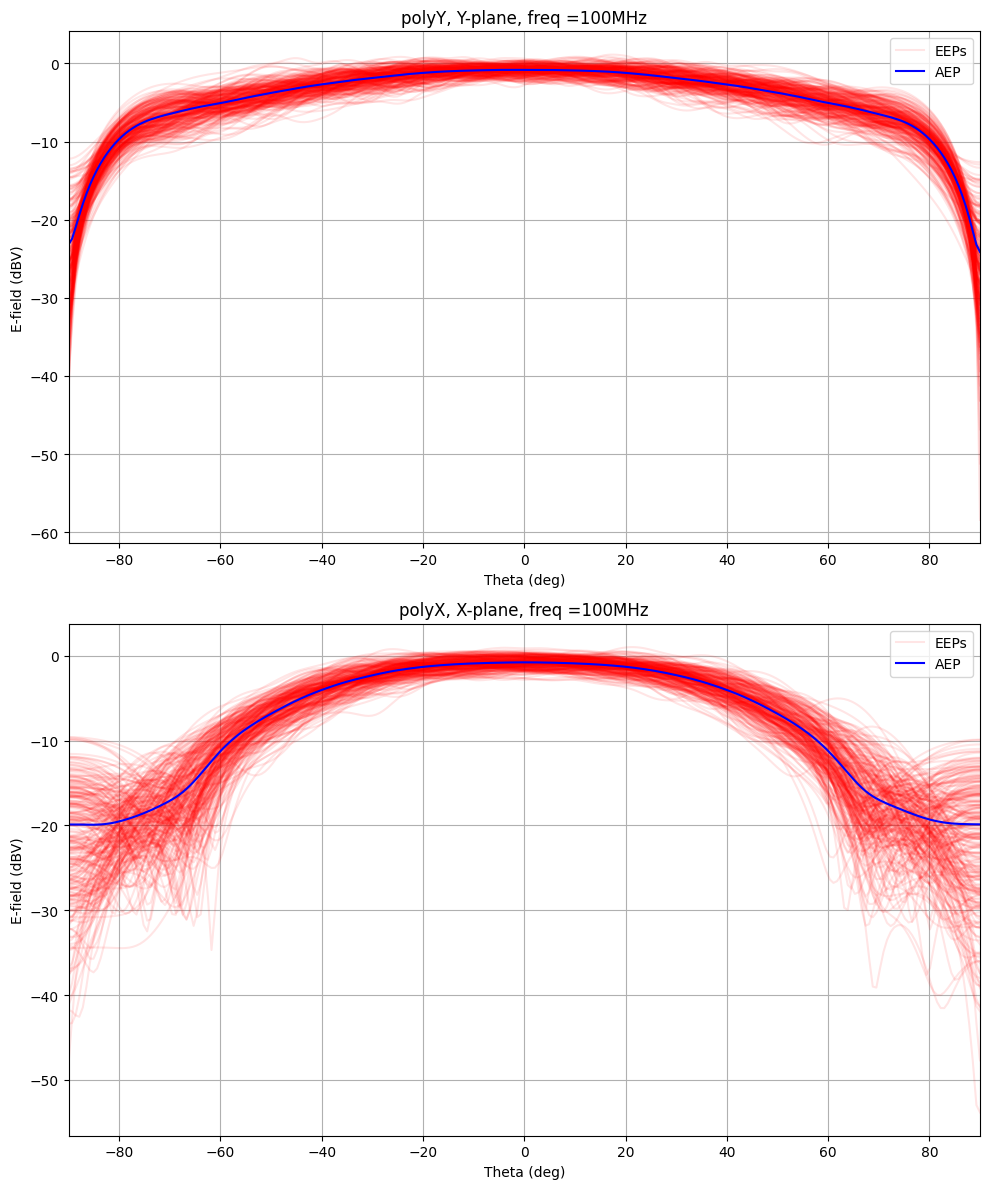

In [2]:
## Q 2. plot all the 256 EEPs and their average (AEP)

num_dir = 256
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = np.zeros_like(theta)

v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Compute EEPs
complex_E_fields = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Compute power EEPs
power_E_fields = power_EEPs(*complex_E_fields)

# plot EEPs and AEPs
plot2(theta, *power_E_fields)


In [3]:
## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as

filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs

Convergence reached after 331 iterations.
Convergence reached after 279 iterations.


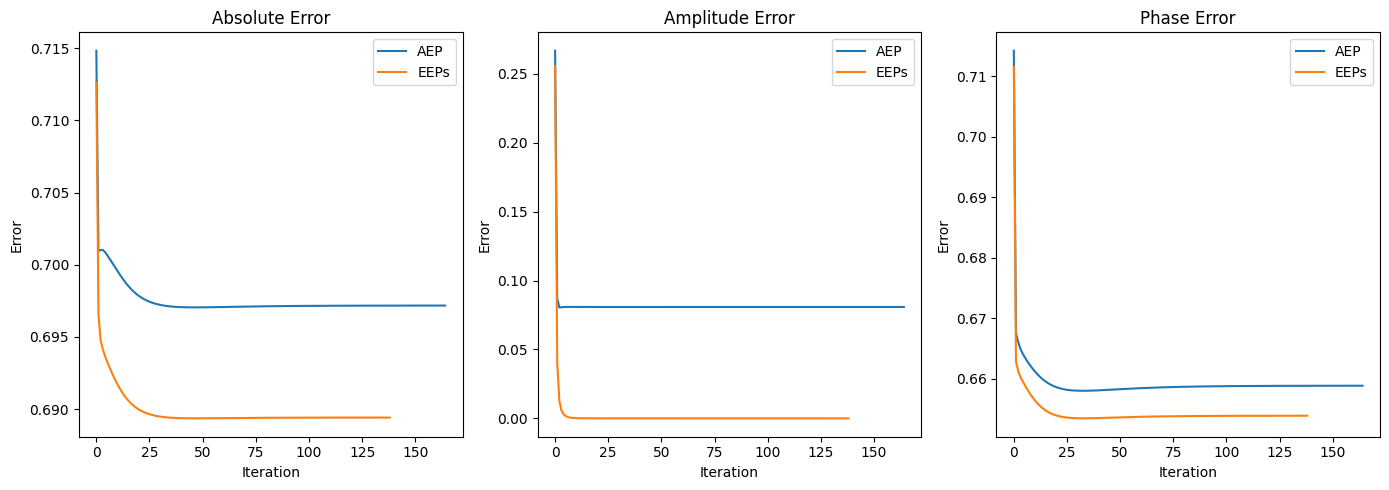

In [4]:
#TODO: Optimise: reduce the number of iterations in the stefcal algorithm and update conergence arguemen


# run stefcal
G_AEP, abs_error_AEP, amp_error_AEP, phase_error_AEP = stefcal(M_AEP, R, g_sol)
G_EEPs, abs_error_EEPs, amp_error_EEPs, phase_error_EEPs = stefcal(M_EEPs, R, g_sol) 

# plot stefcal
plot_stefcal(abs_error_AEP, amp_error_AEP, phase_error_AEP, 
             abs_error_EEPs, amp_error_EEPs, phase_error_EEPs)


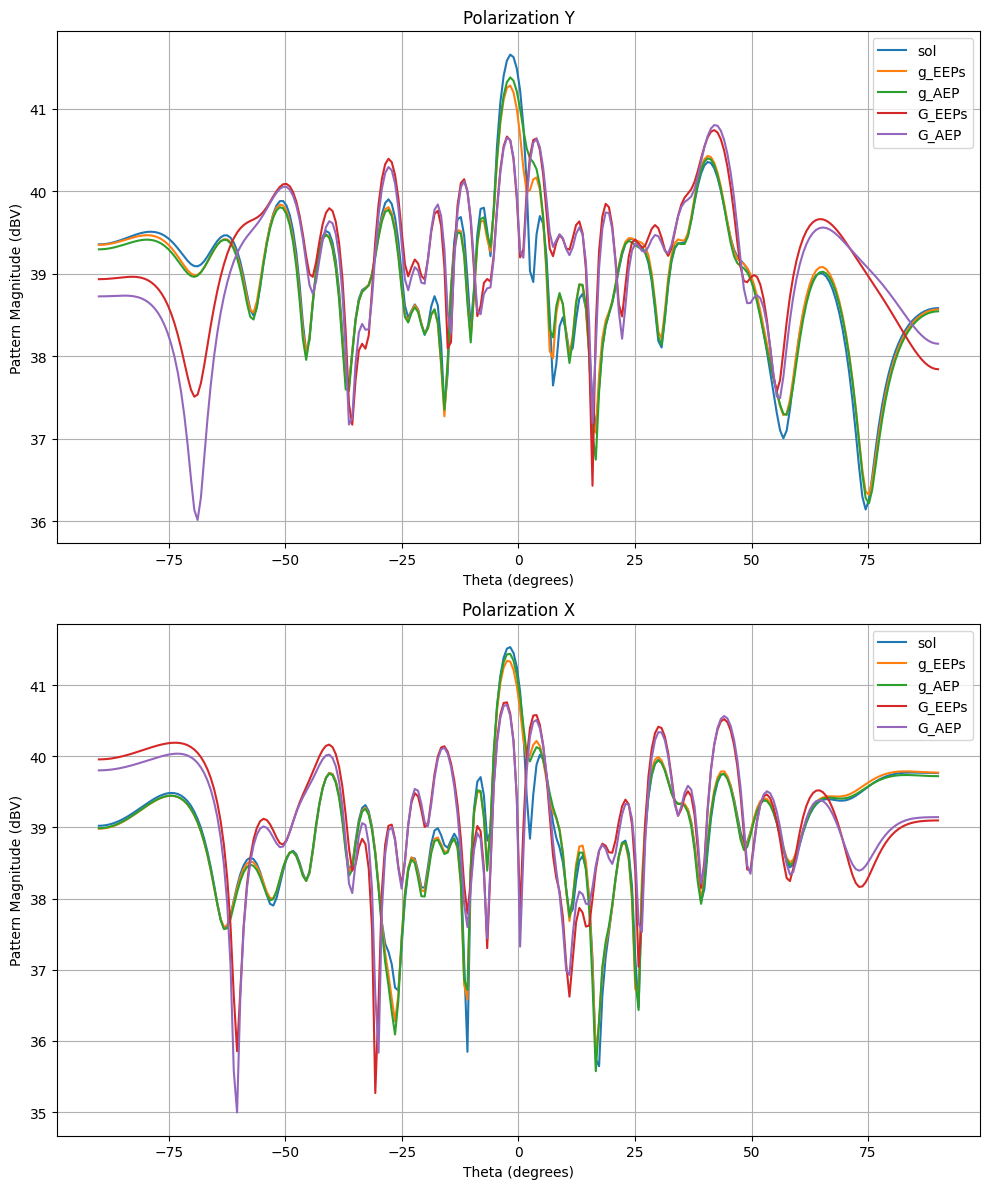

In [5]:
# Q 5. Calibrating EEP using Array Pattern

freq = 100
c0 = 299792458  # speed of light
k0 = 2 * np.pi * freq / c0 * 10**6  # wavenumber
antenna = 'SKALA41'  # antenna name
layout = 'random'  # array layout
data_folder = 'harp_beam'
filename_eep = f"data_EEPs_{antenna}_{layout}_{freq}MHz.mat"
mat = scipy.io.loadmat(filename_eep)
pos_ant = np.array(mat['pos_ant'])

# Define theta_range based on your system (same as your original theta_range)
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = 0
theta0 = 0  # Define theta0 based on your system
phi0 = 0  # Define phi0 based on your system


# AP g_sol
AP_sol_polY, AP_sol_polX = compute_beamforming(g_sol, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP g_EEPs
AP_g_EEPs_polY, AP_g_EEPs_polX = compute_beamforming(g_EEPs, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP g_AEP
AP_g_AEP_polY, AP_g_AEP_polX = compute_beamforming(g_AEP, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP G_EEPs
AP_G_EEPs_polY, AP_G_EEPs_polX = compute_beamforming(G_EEPs.diagonal(), *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP G_AEP
AP_G_AEP_polY, AP_G_AEP_polX = compute_beamforming(G_AEP.diagonal(), *complex_E_fields, pos_ant, theta, phi, theta0, phi0)


# Plot beamforming results
plot_beamforming_results(theta, [to_dBV(AP_sol_polY), to_dBV(AP_g_EEPs_polY), to_dBV(AP_g_AEP_polY), to_dBV(AP_G_EEPs_polY), to_dBV(AP_G_AEP_polY)],
                        [to_dBV(AP_sol_polX), to_dBV(AP_g_EEPs_polX), to_dBV(AP_g_AEP_polX), to_dBV(AP_G_EEPs_polX), to_dBV(AP_G_AEP_polX)],
                        ['sol', 'g_EEPs', 'g_AEP', 'G_EEPs', 'G_AEP'])

In [7]:

# Define theta_range based on your system (same as your original theta_range)
theta_range = np.linspace(-np.pi/2, np.pi/2, num=256)
phi = np.linspace(0, 0, num=256)  # Define phi based on your system
theta0 = 0  # Define theta0 based on your system
phi0 = 0  # Define phi0 based on your system


# Create a grid for theta and phi
theta_vals = np.linspace(-np.pi/2, np.pi/2, num=256)  # -90 to 90 degrees for theta
phi_vals = np.linspace(0, np.pi, num=256)  # -180 to 180 degrees for phi
theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing='ij')
theta0_rad = np.radians(40)
phi0_rad = np.radians(80)


array_pattern_g_sol_theta = np.abs(beamforming(g_sol, v_theta_polX, pos_ant, theta_vals, phi_vals, theta0_rad, phi0_rad))
array_pattern_g_sol_phi = np.abs(beamforming(g_sol, v_phi_polX, pos_ant, theta_vals, phi_vals, theta0_rad, phi0_rad))
array_pattern_sol = to_dBV(array_pattern_g_sol_theta**2 + array_pattern_g_sol_phi**2)

/Users/maxtalberg/Documents/Max/Cambridge2324/Lent/SKA/Coursework/harp_beam/plots.py:131: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = plt.pcolormesh(x, y, AP, shading='auto', cmap=cmap)


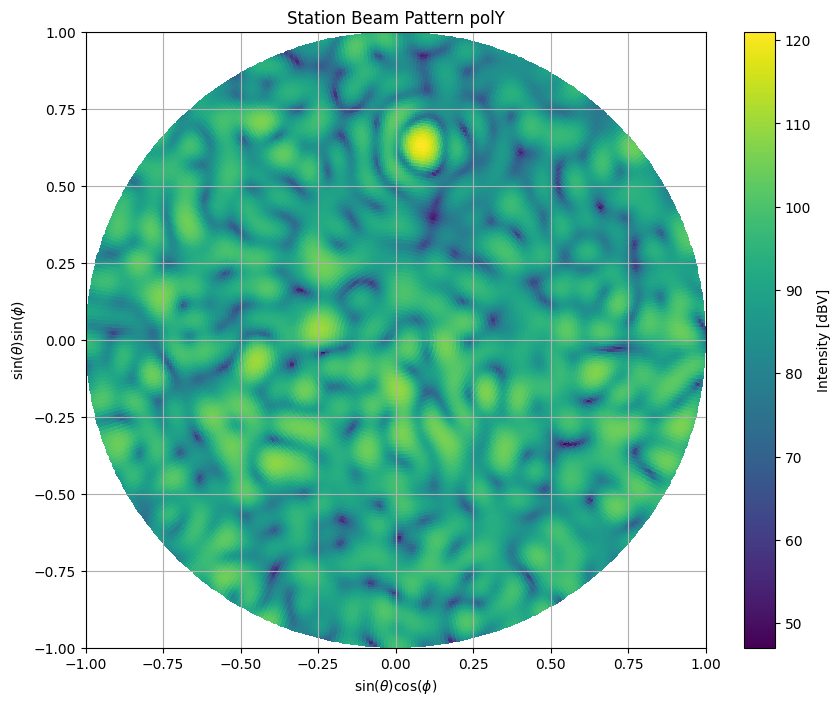

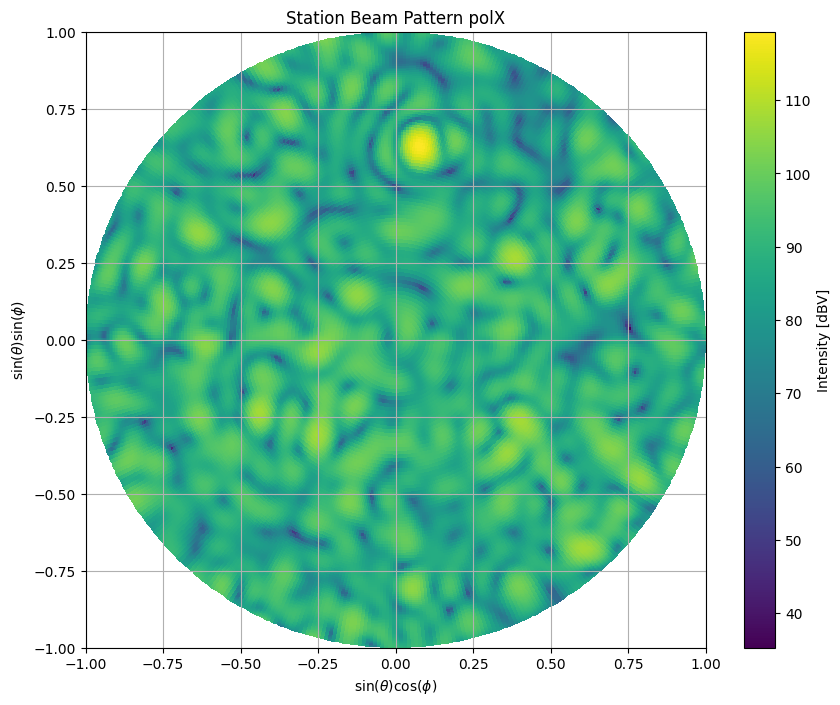

In [8]:
# q6. Plot calibrated station beam in sine-cosine space

# Create a grid for theta and phi
theta_vals = np.linspace(-np.pi/2, np.pi/2, num=256)  # -90 to 90 degrees for theta
phi_vals = np.linspace(0, np.pi, num=256)  # -180 to 180 degrees for phi
theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing='ij')
theta0_rad = np.radians(40)
phi0_rad = np.radians(80)

G = g_sol
AP_ploY, AP_polX = compute_beamforming(G, *complex_E_fields, pos_ant, theta_vals, phi_vals, theta0_rad, phi0_rad)

# Map theta and phi to sine-cosine coordinates
x = np.sin(theta_grid) * np.cos(phi_grid)
y = np.sin(theta_grid) * np.sin(phi_grid)

# Create the plot using pcolormesh, which is more appropriate for spherical data
plot_station_beam_pattern(x, y, AP_ploY, title='Station Beam Pattern polY')
plot_station_beam_pattern(x, y, AP_polX, title='Station Beam Pattern polX')